# Alpha Vantage Sentiment Scores
## Sentiment Score Definition:
x <= -0.35: Bearish \
-0.35 < x <= -0.15: Somewhat-Bearish \
-0.15 < x < 0.15: Neutral \
0.15 <= x < 0.35: Somewhat_Bullish \
x >= 0.35: Bullish 

## Relevance Score Definition: 
0 < x <= 1, with a higher score indicating higher relevance.

In [101]:
# Importing Packages
import json
import pandas as pd
import numpy as np
import datetime as dt

# For financial data
import yfinance as yf

# For statistical tests
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller

In [2]:
def process_json_to_df(json_data):
    # Extract the feed list from JSON
    feed = json_data['feed']
    
    # Create a list to store processed records
    processed_records = []
    
    for item in feed:
        # Create a record dictionary with desired fields
        record = {
            'title': item['title'],
            'url': item['url'],
            'time_published': item['time_published'],
            'summary': item['summary'],
            'source': item['source'],
            'topics': {topic['topic']: topic['relevance_score'] for topic in item['topics']},
            'overall_sentiment_score': item['overall_sentiment_score'],
            'overall_sentiment_label': item['overall_sentiment_label'],
            'ticker_sentiment': {
                ticker['ticker']: {
                    'relevance_score': ticker['relevance_score'],
                    'sentiment_score': ticker['ticker_sentiment_score'],
                    'sentiment_label': ticker['ticker_sentiment_label']
                } for ticker in item['ticker_sentiment']
            }
        }
        processed_records.append(record)
    
    # Convert to DataFrame
    df = pd.DataFrame(processed_records)
    
    return df

In [28]:
def combine_sentiment_files(tickers):
    # List to store individual dataframes
    dfs = []
    
    for ticker in tickers:
        # Extract ticker from filename
        file = f"news_sentiment_{ticker}.json"
        
        # Read JSON file
        with open(file, 'r', encoding='utf-8') as f:
            json_data = json.load(f)
        
        # Process JSON data using your existing function
        temp_df = process_json_to_df(json_data)
        
        # Add ticker column
        temp_df['ticker'] = ticker
        
        # Select only required columns
        temp_df = temp_df[['ticker', 'time_published', 'overall_sentiment_score']]
        
        dfs.append(temp_df)
    
    # Combine all dataframes
    final_df = pd.concat(dfs, ignore_index=True)
    
    # Convert time_published to datetime (assuming format like "20241231T101500")
    final_df['time_published'] = pd.to_datetime(final_df['time_published'], format='%Y%m%dT%H%M%S')
    
    # Sort by time_published
    final_df = final_df.sort_values('time_published')
    final_df.index = final_df['time_published'].dt.date
    
    return final_df

In [58]:
start_date = '2022-03-01'
end_date = '2024-12-31'

def get_gold_price(start_date, end_date):
    gold_ticker = 'GC=F'  # Gold Futures ticker symbol
    gold_data = yf.download(gold_ticker, start=start_date, end=end_date)
    gold_prices = gold_data['Close']
    return gold_prices

def get_log_returns(df):
    return np.log(df/df.shift(1))

# Simple Linear Interpolation

In [96]:
def get_gold_sentiment_score_linear_interpolation(df):
    sentiment_df = pd.DataFrame(df.groupby(df.index)['overall_sentiment_score'].mean())

    new_index = pd.date_range(start=sentiment_df.index.min(),
                            end=sentiment_df.index.max(),  
                            freq='B')

    sentiment_df = sentiment_df.reindex(new_index).interpolate(method='time')
    return sentiment_df

[*********************100%***********************]  1 of 1 completed


,GC=F,overall_sentiment_score
2022-03-02,-0.011130,-0.106392
2022-03-03,0.007003,-0.056277
2022-03-04,0.015746,-0.006163
2022-03-07,0.014549,0.144180
2022-03-08,0.022906,0.066281
...,...,...
2024-12-23,-0.006258,0.258426
2024-12-24,0.002943,0.265832
2024-12-26,0.007150,0.297236
2024-12-27,-0.008219,0.193185


c:\Users\regan\Documents\NUS\NUS Modules\Year 4 Semester 2\IS3107 Data Engineering\Project\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Gold Returns: ADF Stat: -12.34, p-value: 0.0000
Sentiment: ADF Stat: -3.13, p-value: 0.0247

Granger Causality Results (Sentiment → Gold Returns):
Lag 1: F-stat = 0.11, p-value = 0.7377 
Lag 2: F-stat = 2.31, p-value = 0.3145 
Lag 3: F-stat = 2.55, p-value = 0.4659 
Lag 4: F-stat = 5.15, p-value = 0.2723 
Lag 5: F-stat = 6.44, p-value = 0.2653 


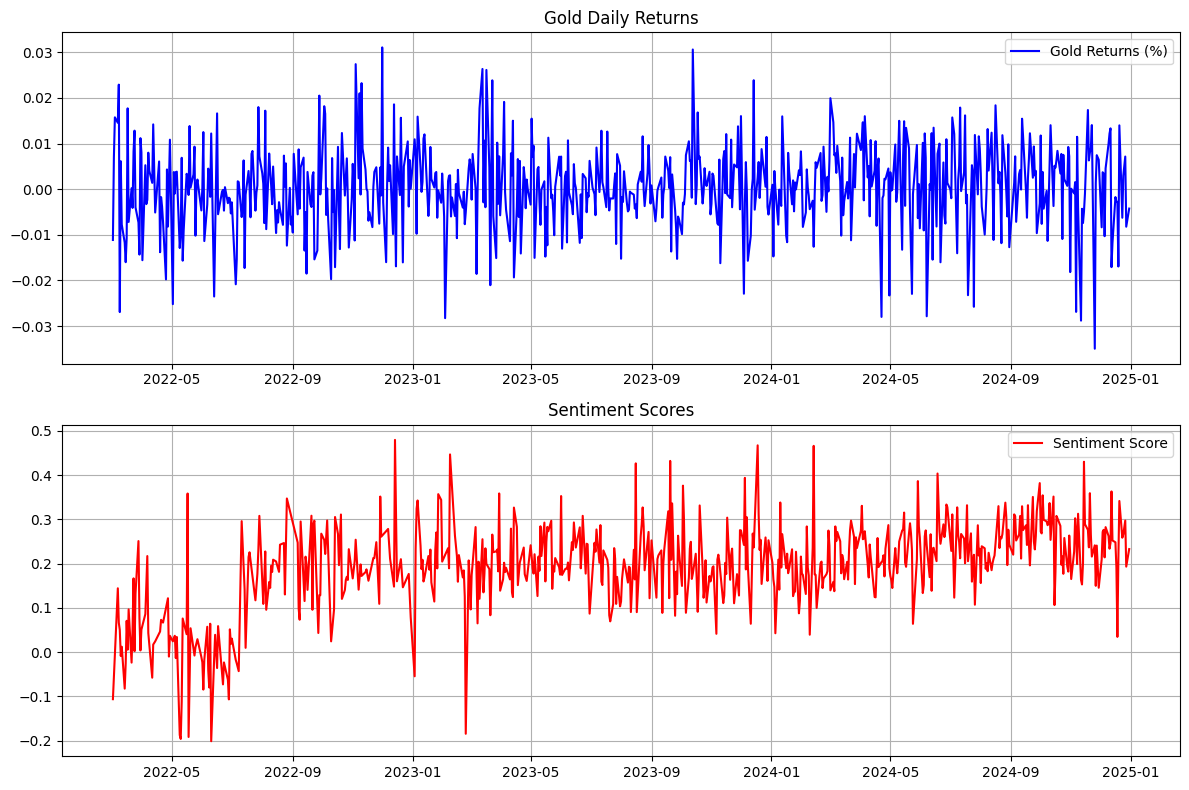


Correlation between Returns and Sentiment:
                             GC=F  overall_sentiment_score
GC=F                     1.000000                 0.049917
overall_sentiment_score  0.049917                 1.000000


In [132]:
# Getting information
tickers = ["AEM", "FNV", "GFI", "GOLD", "KGC", "NEM", "WPM"]
final_df = combine_sentiment_files(tickers)
gold_sentiment = get_gold_sentiment_score_linear_interpolation(final_df)
gold_log_returns = get_log_returns(get_gold_price(start_date, end_date))

combined_df = pd.merge(gold_log_returns, gold_sentiment, left_index=True, right_index=True).dropna()
display(combined_df)

# Stationary Test
def check_stationarity(series):
    result = adfuller(series)
    return f"ADF Stat: {result[0]:.2f}, p-value: {result[1]:.4f}"
print("Gold Returns:", check_stationarity(combined_df['GC=F']))
print("Sentiment:", check_stationarity(combined_df['overall_sentiment_score']))

# Both gold log returns and sentiment are stationary

# Granger causality test
max_lag = 5
test_result = grangercausalitytests(combined_df[['GC=F', 'overall_sentiment_score']], 
                                   maxlag=max_lag, 
                                   verbose=False)

print("\nGranger Causality Results (Sentiment → Gold Returns):")
for lag in range(1, max_lag+1):
    p_value = test_result[lag][0]['ssr_chi2test'][1]
    f_stat = test_result[lag][0]['ssr_chi2test'][0]
    print(f"Lag {lag}: F-stat = {f_stat:.2f}, p-value = {p_value:.4f} {'*' if p_value < 0.05 else ''}")

# Visualization
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot returns
ax1.plot(combined_df['GC=F'], label='Gold Returns (%)', color='blue')
ax1.set_title('Gold Daily Returns')
ax1.legend()
ax1.grid(True)

# Plot sentiment
ax2.plot(combined_df['overall_sentiment_score'], label='Sentiment Score', color='red')
ax2.set_title('Sentiment Scores')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\nCorrelation between Returns and Sentiment:")
print(combined_df.corr())

Using simple linear interpolation, we can see that the sentiment does not Granger-cause gold returns. Furthermore, sentiment score has a low correlation with gold returns. Hence, could suggest that it is not a good predictor of gold returns.

# Exponential Decay

In [129]:
def get_gold_sentiment_score_exponential_decay(df):
    sentiment_df = pd.DataFrame(df.groupby(df.index)['overall_sentiment_score'].mean())

    date_range = pd.date_range(start=sentiment_df.index.min(), 
                            end=sentiment_df.index.max(),
                            freq = "B")

    def decay_function(days, initial_value):
        decay_constant = np.log(100) / 7
        return initial_value * np.exp(-decay_constant * days) * (days <= 7)

    # Create list to store individual column series
    columns_data = []

    # Process each date and its sentiment
    for date, sentiment in zip(sentiment_df.index, df['overall_sentiment_score']):
        date = pd.to_datetime(date)
        days_diff = (date_range - date).days
        decayed_values = [decay_function(d, sentiment) if d >= 0 else 0 for d in days_diff]
        
        # Create a Series for this date's decay values
        column_series = pd.Series(decayed_values, index=date_range, name=date)
        columns_data.append(column_series)

    # Concatenate all columns at once
    result = pd.concat(columns_data, axis=1)

    # Get final sentiment (sum of all decay effects)
    final_sentiment = result.sum(axis=1)
    return pd.DataFrame(final_sentiment, columns=["Sentiment Score"])

[*********************100%***********************]  1 of 1 completed


,GC=F,Sentiment Score
2022-03-02,-0.011130,-0.081062
2022-03-03,0.007003,-0.041986
2022-03-04,0.015746,-0.021746
2022-03-07,0.014549,0.141158
2022-03-08,0.022906,0.139394
...,...,...
2024-12-23,-0.006258,0.204216
2024-12-24,0.002943,0.254424
2024-12-26,0.007150,0.266534
2024-12-27,-0.008219,0.457155


c:\Users\regan\Documents\NUS\NUS Modules\Year 4 Semester 2\IS3107 Data Engineering\Project\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Gold Returns: ADF Stat: -12.34, p-value: 0.0000
Sentiment: ADF Stat: -1.72, p-value: 0.4219

Granger Causality Results (Sentiment → Gold Returns):
Lag 1: F-stat = 0.00, p-value = 0.9471 
Lag 2: F-stat = 0.00, p-value = 0.9997 
Lag 3: F-stat = 1.12, p-value = 0.7712 
Lag 4: F-stat = 1.35, p-value = 0.8527 
Lag 5: F-stat = 1.92, p-value = 0.8600 


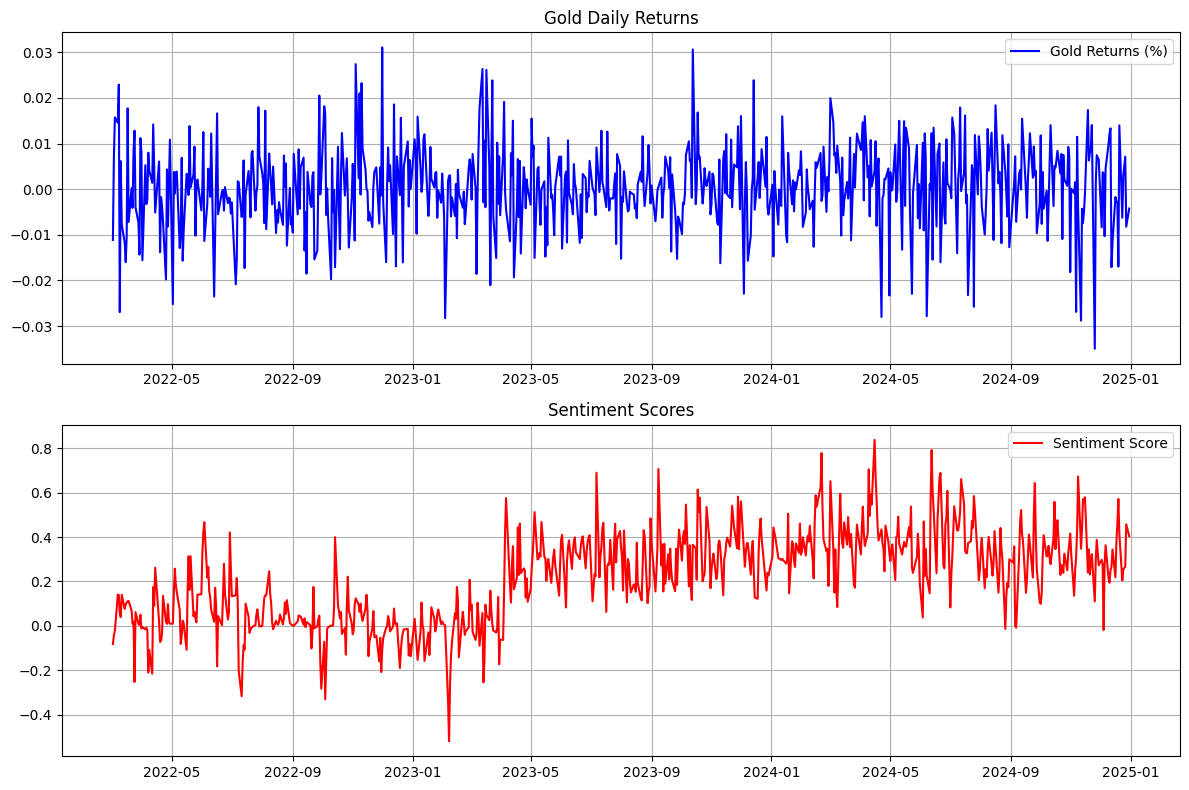


Correlation between Returns and Sentiment:
                     GC=F  Sentiment Score
GC=F             1.000000         0.032182
Sentiment Score  0.032182         1.000000


In [134]:
# Getting information
tickers = ["AEM", "FNV", "GFI", "GOLD", "KGC", "NEM", "WPM"]
final_df = combine_sentiment_files(tickers)
gold_sentiment = get_gold_sentiment_score_exponential_decay(final_df)
gold_log_returns = get_log_returns(get_gold_price(start_date, end_date))

combined_df = pd.merge(gold_log_returns, gold_sentiment, left_index=True, right_index=True).dropna()
display(combined_df)

# Stationary Test
def check_stationarity(series):
    result = adfuller(series)
    return f"ADF Stat: {result[0]:.2f}, p-value: {result[1]:.4f}"
print("Gold Returns:", check_stationarity(combined_df['GC=F']))
print("Sentiment:", check_stationarity(combined_df['Sentiment Score']))

# Both gold log returns and sentiment are stationary

# Granger causality test
max_lag = 5
test_result = grangercausalitytests(combined_df[['GC=F', 'Sentiment Score']], 
                                   maxlag=max_lag, 
                                   verbose=False)

print("\nGranger Causality Results (Sentiment → Gold Returns):")
for lag in range(1, max_lag+1):
    p_value = test_result[lag][0]['ssr_chi2test'][1]
    f_stat = test_result[lag][0]['ssr_chi2test'][0]
    print(f"Lag {lag}: F-stat = {f_stat:.2f}, p-value = {p_value:.4f} {'*' if p_value < 0.05 else ''}")

# Visualization
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot returns
ax1.plot(combined_df['GC=F'], label='Gold Returns (%)', color='blue')
ax1.set_title('Gold Daily Returns')
ax1.legend()
ax1.grid(True)

# Plot sentiment
ax2.plot(combined_df['Sentiment Score'], label='Sentiment Score', color='red')
ax2.set_title('Sentiment Scores')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\nCorrelation between Returns and Sentiment:")
print(combined_df.corr())

Granger causality test shows even worse result when we do exponential decay followed by summing of the values. Correlation scores are still low.